In [1]:
import genjax
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
from jax import jit
from jax import grad
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

console = genjax.pretty()

In [2]:
@genjax.dist
def new_dist(x):
    v = genjax.rv(genjax.Normal)(x, 1.0)
    return jnp.exp(v / 2.0) + 2.0

In [3]:
# Recreates the Oryx example.
def show_plot(mean):
    vs = jit(vmap(new_dist.sample, in_axes=(0, None)))(
        jax.random.split(jax.random.PRNGKey(0), 1000), mean
    )
    x = jnp.linspace(0.0, 8, 100)
    scores = jnp.exp(jit(vmap(new_dist.logpdf, in_axes=(0, None)))(x, mean))
    _, ax = plt.subplots(2, sharex=True)
    ax[0].hist(vs, bins="auto")
    ax[1].plot(x, scores)
    plt.show()

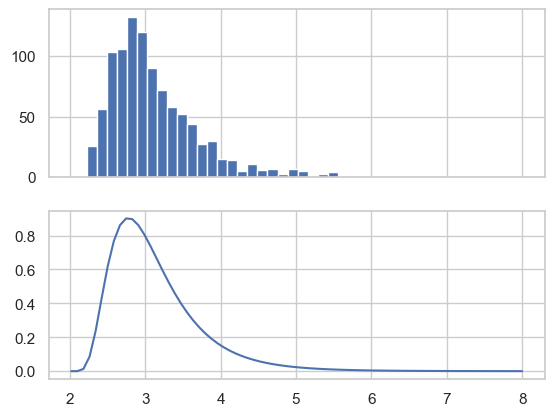

In [4]:
show_plot(0.0)

## Labeled Bernoulli

In [5]:
labels = jnp.array([1.0, 0.0])

@genjax.dist
def labeled_bernoulli(p):
    v = genjax.rv(genjax.Bernoulli)(p)
    v = jnp.array(v, int)
    return labels[v]

In [6]:
# Sampling forward is okay.
key = jax.random.PRNGKey(0)
v = labeled_bernoulli.sample(key, 0.3)
v

Array(0., dtype=float32)

In [7]:
# Inversion currently breaks.
score = labeled_bernoulli.logpdf(0.0, 1.0)
score

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/mk/btkplz1n40q001dsy957srbh0000gn/T/ipykernel_60084/656988919.py:2 in <module>      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/mk/btkplz1n40q001dsy957srbh0000gn/T/ipykernel_60084/656988919.py'                  │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/src/genjax/_src/generative_functions/distributions/coryx/lang │
│ .py:193 in logpdf                                                                                │
│                                                                                                  │
│   190 │   │   def scorer(constraints):                                                           │
│   191 │   │   │   return sow_transform(self.source, constraints)(*args)[1]                       │
│   192 │   │                                                                                      │
│ ❱ 193 │   │   inverses, ildj_correction = inverse_core.inverse_and_ildj(returner)(v)             │
│   194 │   │   score = scorer(inverses) + ildj_correction                                         │
│   195 │   │   return score                                                                       │
│   196                                                                                            │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/src/genjax/_src/generative_functions/distributions/coryx/core │
│ .py:175 in wrapped                                                                               │
│                                                                                                  │
│   172 │   │   flat_incells = [InverseAndILDJ.unknown(aval) for aval in flat_forward_avals]       │
│   173 │   │   flat_outcells = safe_map(InverseAndILDJ.new, flat_args)                            │
│   174 │   │   with propagate.Interpreter.new(InverseAndILDJ, ildj_registry) as interpreter:      │
│ ❱ 175 │   │   │   env, _ = interpreter(                                                          │
│   176 │   │   │   │   jaxpr.jaxpr,                                                               │
│   177 │   │   │   │   flat_constcells,                                                           │
│   178 │   │   │   │   flat_incells,                                                              │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/src/genjax/_src/core/interpreters/graph.py:486 in __call__    │
│                                                                                                  │
│   483 │   │   incells: List[Cell],                                                               │
│   484 │   │   outcells: List[Cell],                                                              │
│   485 │   ) -> Tuple[Environment, State]:                                                        │
│ ❱ 486 │   │   return self.eval(jaxpr, constcells, incells, outcells)                             │
│   487                                                                                            │
│   488                                                                                            │
│   489 @lu.transformation_with_aux                                                                │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/src/genjax/_src/core/interpreters/graph.py:453 in eval        │
│                                                            

## Programs which should fail

In [ ]:
@genjax.dist
def new_dist(x):
    v = genjax.rv(genjax.Normal)(x, 1.0)
    return jnp.cos(v), jnp.sin(v)

In [ ]:
# Sampling forward is okay.
key = jax.random.PRNGKey(0)
v = new_dist.sample(key, 1.0)
v

In [ ]:
# Inversion should break.
key = jax.random.PRNGKey(314159)
score = new_dist.logpdf(v, 1.0)
score